![](../images/itam_logo.png)

M. Sc. Liliana Millán Núñez liliana.millan@itam.mx

Diciembre 2020

### Aequitas

>Este notebook se genera a partir del notebook oficial de [Aequitas](https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)

Ocuparemos los datos de Compas ya preparados para Aequitas que puedes encontrar [aquí](https://www.dropbox.com/s/8zqh3pji58juteh/compas_for_aequitas.csv?dl=0)

COMPAS produce un score de riesgo asociado a la probabilidad de que cometer un crimen en los siguientes dos años. 
La salida es un score entre 1 y 10 que se mapea a un categoría baja, media o alta de riesgo. 

Para esta demo de Aequitas, modificaron esta predicción a que fuera binaria, donde un 0 indica una predicción asociada a bajo riesgo y 1 indica una predicción de riesgo alto o medio.

Para ocupar el *framework* de Aequitas, tendrás que instalar en tu `pyenv` el paquete `aequitas` con `pip install aequitas`.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [2]:
compas = pd.read_csv("../../datasets/compas_for_aequitas.csv")

In [3]:
compas.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [4]:
compas.race.unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

### EDA antes de Aequitas

Atributo `race`: ¿Cómo se distribuye el score del modelo en las diferentes categorías que forman parte del atributo `race`?

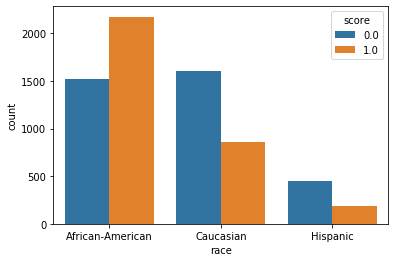

In [5]:
by_race = sns.countplot(x="race", hue="score", 
                        data=compas[compas.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

Atributo `sex`: ¿Cómo se distribuye el score del modelo en las diferentes categorías del atributo `sex`?

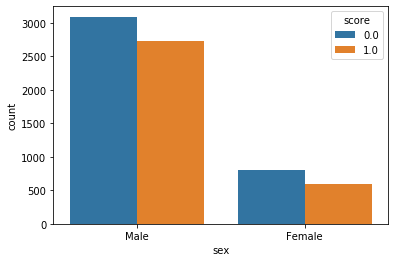

In [6]:
by_sex = sns.countplot(x="sex", hue="score", data=compas)

Atributo `age`: ¿Cómo se distribuye el score del modelo en las diferentes categorías del atributo `age`?

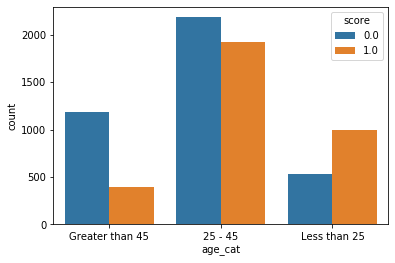

In [7]:
by_age = sns.countplot(x="age_cat", hue="score", data=compas)

¿Cómo está la distribución de las etiquetas en el atributo `race`?

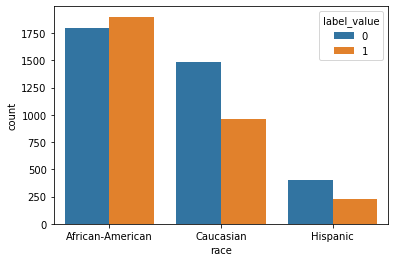

In [8]:
label_by_race = sns.countplot(x="race", hue="label_value", 
                              data=compas[compas.race.isin(['African-American', 'Caucasian', 'Hispanic'])])

¿Cómo está la distribución de las etiquetas en el atributo `sex`?

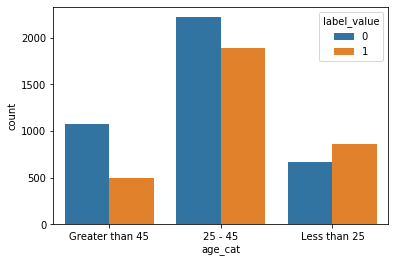

In [9]:
label_by_sex = sns.countplot(x="age_cat", hue="label_value", data=compas)

¿Cómo está la distribución de las etiquetas en el atributo `age`?

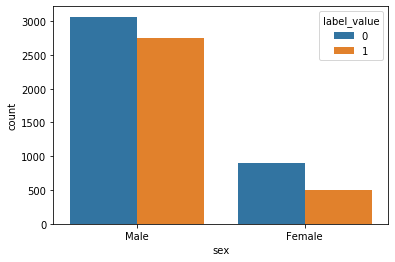

In [10]:
label_by_age = sns.countplot(x="sex", hue="label_value", data=compas)

### Usando Aequitas

Para utilizar Aequitas se tiene que interactuar con 3 clases: 
    
1. `Group()`: Definimos los grupos
2. `Bias()`: Calculamos disparidad
3. `Fairness()`: Decidimos si es justo o no

`Bias` depende de `Group` y `Fairness` de `Bias`, por lo que se requiere de ocuparlas en el orden presentado.

Para ocupar Aequitas en necesario que exista una columna `score` y una columna `label_value` binaria. La primera corresponde a la etiqueta predicha del modelo -de acuerdo a cierto punto de *threshold*-, la segunda a la etiqueta real.

#### Group

Esta clase nos servirá para evaluar sesgo en los subgrupos que existen en el *dataset*. Para evaluar este sesgo Aequitas ocupa una matriz de confusión para cada subgrupo utilizando las métricas seleccionadas como parte del reporte; además agrega los conteos por grupo y la prevalencia por grupo. 

Esta clase ocupa el método `get_crosstabs()` que genera esta matriz de confusión por cada subgrupo. Este método recibe un *dataframe* que debe tener el `score`, el `label_value` y el resto de columnas que vengan en el *dataframe* son interpretadas como las variables sobre las que hay que realizar el *crosstabs*.

La salida del método `get_crosstabs()` consiste en la tabla generada de crosstabs y las variables a las que se les aplicó el `crosstabs`. En la tabla se regresan tanto las métricas de conteo por grupo como las métricas absolutas por grupo: 

Métricas de conteo por grupo: 

|Count Type|Column Name|
|:--------------|:------------|
|False Positive Count|'fp'|
|False Negative Count|'fn'|
|True Negative Count|'tn'|
|True Positive Count|'tp'|
|Predicted Positive Count|'pp'|
|Predicted Negative Count|'pn'|
|Count of Negative Labels in Group|'group_label_neg'|
|Count of Positive Labels in Group|'group_label_pos'|
|Group Size|'group_size'|
|Total Entities|'total_entities'|

Métricas absolutas por grupo:

|Metric|Column Name|
|:---------|:-----------|
True Positive Rate|'tpr'|
True Negative Rate|'tnr'|
False Omission Rate|'for'|
False Discovery Rate|'fdr'|
|False Positive Rate|'fpr'|
|False Negative Rate|'fnr'|
|Negative Predictive Value|'npv'|
|Precision|'precision'|
|Predicted Positive Ratio `_k` |'ppr'|
|Predicted Positive Ratio `_g` |'pprev'|
|Group Prevalence|'prev'

In [11]:
g = Group()
xtab, attrbs = g.get_crosstabs(compas)

model_id, score_thresholds 1 {'rank_abs': [3317]}


In [12]:
# la tabla de crosstabs
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,...,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340
1,1,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,...,0.250000,2,3,21,6,9,23,32,7214,0.281250
2,1,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,...,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643
3,1,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,...,0.298273,87,129,318,103,232,405,637,7214,0.364207
4,1,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,...,0.666667,3,1,5,9,10,8,18,7214,0.555556
5,1,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,...,0.209549,36,90,208,43,133,244,377,7214,0.352785
6,1,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,...,0.423656,288,195,609,303,498,897,1395,7214,0.356989
7,1,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,...,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105
8,1,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,...,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723
9,1,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,...,0.250000,181,285,897,213,498,1078,1576,7214,0.315990


In [13]:
attrbs

Index(['race', 'sex', 'age_cat'], dtype='object')

Para solo obtener las métricas absolutas por grupo puedes ocupar el método `list_absolute_metrics()` y con la "diferencia" las métricas de conteo de grupos.

In [14]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [15]:
absolute_metrics

['tpr',
 'tnr',
 'for',
 'fdr',
 'fpr',
 'fnr',
 'npv',
 'precision',
 'ppr',
 'pprev',
 'prev']

Conteos por grupo

In [16]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
1,1,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
2,1,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
3,1,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
4,1,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214
5,1,binary 0/1,3317,race,Other,79,298,36,90,208,43,133,244,377,7214
6,1,binary 0/1,3317,sex,Female,591,804,288,195,609,303,498,897,1395,7214
7,1,binary 0/1,3317,sex,Male,2726,3093,994,1021,2072,1732,2753,3066,5819,7214
8,1,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
9,1,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214


Absolutos por grupo

In [17]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32


#### Visualización del sesgo en los grupos

Para visualizar el sesgo se pueden ocupar dos métodos: 

1. `plot_group_metric()`: Visualiza 1 sola métrica.
2. `plot_group_metric_all()`: Visualiza varias métricas a la vez

Para utilizarlas primero tendremos que instanciar la clase `Plot`

In [18]:
aeq = Plot()

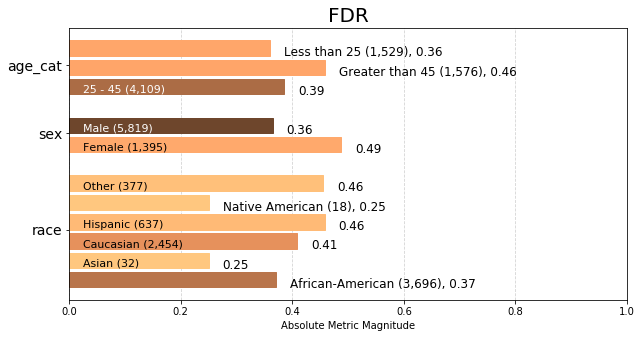

In [19]:
fdr = aeq.plot_group_metric(xtab, 'fdr')

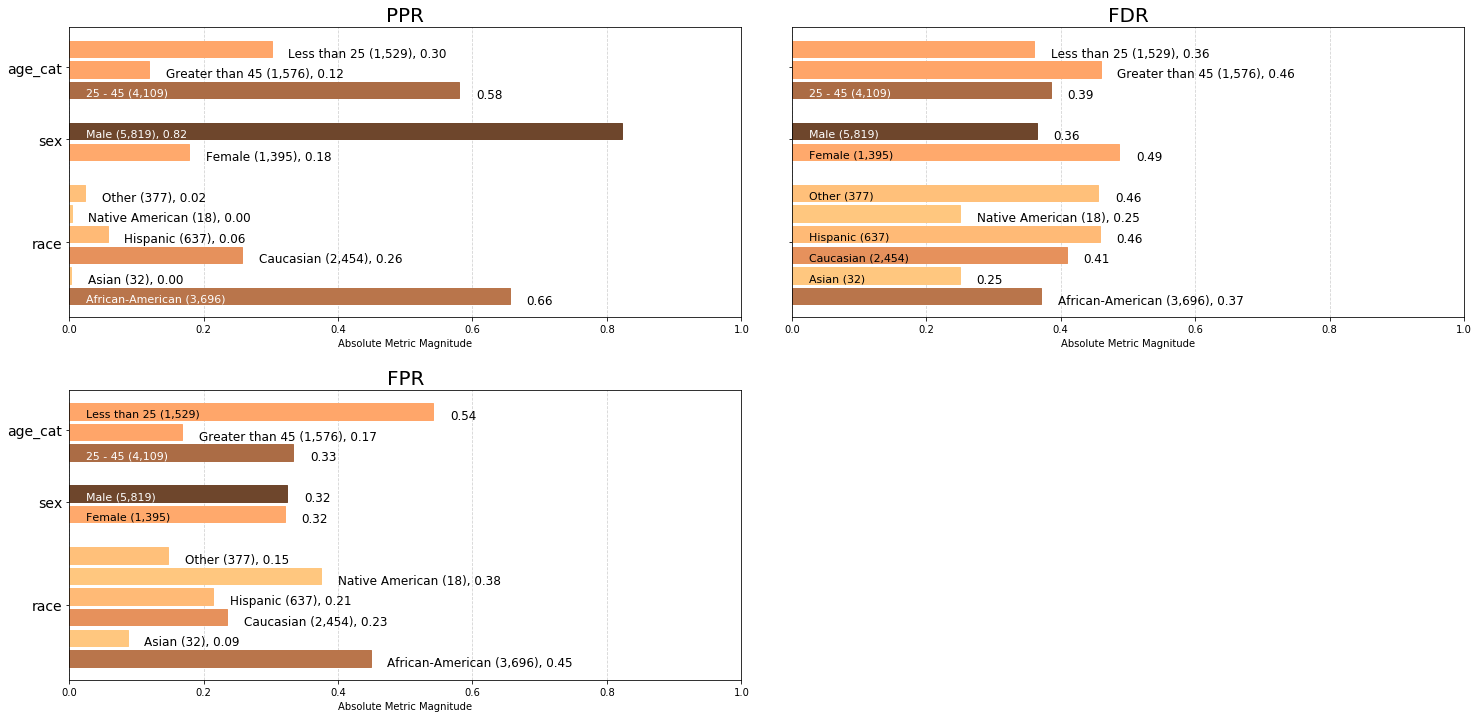

In [20]:
p = aeq.plot_group_metric_all(xtab, metrics=['ppr','fdr','fpr'], ncols=2)

### Bias

Ahora tenemos que calcular las disparidades entre los diferentes grupos por cada métrica de interés. 

Tendremos que definir cuál será el grupo de referencia para que después se puedan calcular las disparidades. Esta definición se puede hacer de 3 formas: 

1. `get_disparity_predefined_groups()`: Lo definimos nosotros.
2. `get_disparity_major_group()`: El grupo de referencia es el que mayor número de observaciones tiene en el dataset.
3. `get_disparity_min_metric()`: El grupo de referencia es el que menor valor de cada métrica solicitada tenga. 

Una vez que se calculan las disparidades puedes obtenerlas a través del método `list_disparities()`.

Se pueden calcular las siguiente métricas de disparidad: 

|Metric|Column Name|
|:-------------------------------|:------------|
|True Positive Rate Disparity|'tpr_disparity'|
|True Negative Rate|'tnr_disparity'|
|False Omission Rate|'for_disparity'|
|False Discovery Rate|'fdr_disparity'|
|False Positive Rate|'fpr_disparity'|
|False NegativeRate|'fnr_disparity'|
|Negative Predictive Value|'npv_disparity'|
|Precision Disparity|'precision_disparity'|
|Predicted Positive Ratio `_k` Disparity|'ppr_disparity'|
|Predicted Positive Ratio `_g` Disparity|'pprev_disparity'|


In [21]:
bias = Bias()

In [22]:
bdf = bias.get_disparity_predefined_groups(xtab, original_df=compas, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}, 
                                        alpha=0.05)

get_disparity_predefined_group()


/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


In [37]:
# View disparity metrics added to dataframe
bdf_ = bdf[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bdf)].round(2)

In [38]:
bdf_[['attribute_name', 'attribute_value', 'fdr_disparity', 'for_disparity', 'fpr_disparity', 'fnr_disparity']]

,attribute_name,attribute_value,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity
0,race,African-American,0.91,1.21,1.91,0.59
1,race,Asian,0.61,0.43,0.37,0.70
2,race,Caucasian,1.00,1.00,1.00,1.00
3,race,Hispanic,1.12,1.00,0.92,1.17
4,race,Native American,0.61,0.58,1.60,0.21
5,race,Other,1.12,1.05,0.63,1.42
6,sex,Female,1.34,0.73,0.99,1.06
7,sex,Male,1.00,1.00,1.00,1.00
8,age_cat,25 - 45,1.00,1.00,1.00,1.00
9,age_cat,Greater than 45,1.19,0.75,0.50,1.53


In [24]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=compas)

get_disparity_major_group()


/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/bias.py:233: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


In [25]:
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,race,Asian,0.00,0.43,1.19,0.68,0.36,0.19,1.19,0.93,1.66,1.35
2,race,Caucasian,0.39,0.59,0.94,1.10,0.82,0.52,1.71,0.73,1.39,1.09
3,race,Hispanic,0.09,0.51,0.86,1.24,0.83,0.48,1.99,0.62,1.42,1.09
4,race,Native American,0.01,1.13,1.19,0.68,0.48,0.84,0.36,1.25,1.13,1.28
5,race,Other,0.04,0.36,0.86,1.23,0.86,0.33,2.42,0.45,1.55,1.07
6,sex,Female,0.22,0.90,0.81,1.34,0.73,0.99,1.06,0.97,1.00,1.13
7,sex,Male,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8,age_cat,25 - 45,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,age_cat,Greater than 45,0.20,0.53,0.88,1.19,0.75,0.50,1.53,0.68,1.25,1.12


In [26]:
min_bdf = bias.get_disparity_min_metric(xtab, original_df=compas)

get_disparity_min_metric()


/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/bias.py:99: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if any(pd.np.isnan(val) for val in idxmin.values):
/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/bias.py:133: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)


In [27]:
min_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(min_bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,271.75,2.81,1.16,1.48,2.80,5.16,2.80,2.23,1.00,1.00
1,race,Asian,1.00,1.19,1.38,1.00,1.00,1.00,3.33,2.06,1.66,1.35
2,race,Caucasian,106.75,1.66,1.09,1.63,2.31,2.70,4.77,1.62,1.39,1.09
3,race,Hispanic,23.75,1.42,1.00,1.83,2.31,2.47,5.56,1.37,1.42,1.09
4,race,Native American,1.50,3.18,1.38,1.00,1.33,4.31,1.00,2.78,1.13,1.28
5,race,Other,9.88,1.00,1.00,1.82,2.42,1.70,6.77,1.00,1.55,1.07
6,sex,Female,1.00,1.00,1.00,1.34,1.00,1.00,1.06,1.00,1.00,1.13
7,sex,Male,4.61,1.11,1.24,1.00,1.36,1.01,1.00,1.03,1.00,1.00
8,age_cat,25 - 45,4.88,1.87,1.14,1.07,1.34,1.99,1.44,1.46,1.45,1.18
9,age_cat,Greater than 45,1.00,1.00,1.00,1.27,1.00,1.00,2.20,1.00,1.81,1.32


### Visualización de disparidades

Para visualizar las disparidades puedes ocupar dos métodos: 

1. `plot_disparity()`: Visualización de 1 métrica.
2. `plot_disparity_all()`: Visualización de varias métricas a la vez.

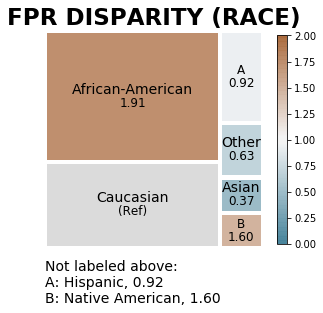

In [28]:
fpr_disparity = aeq.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', 
                                   significance_alpha=0.05)

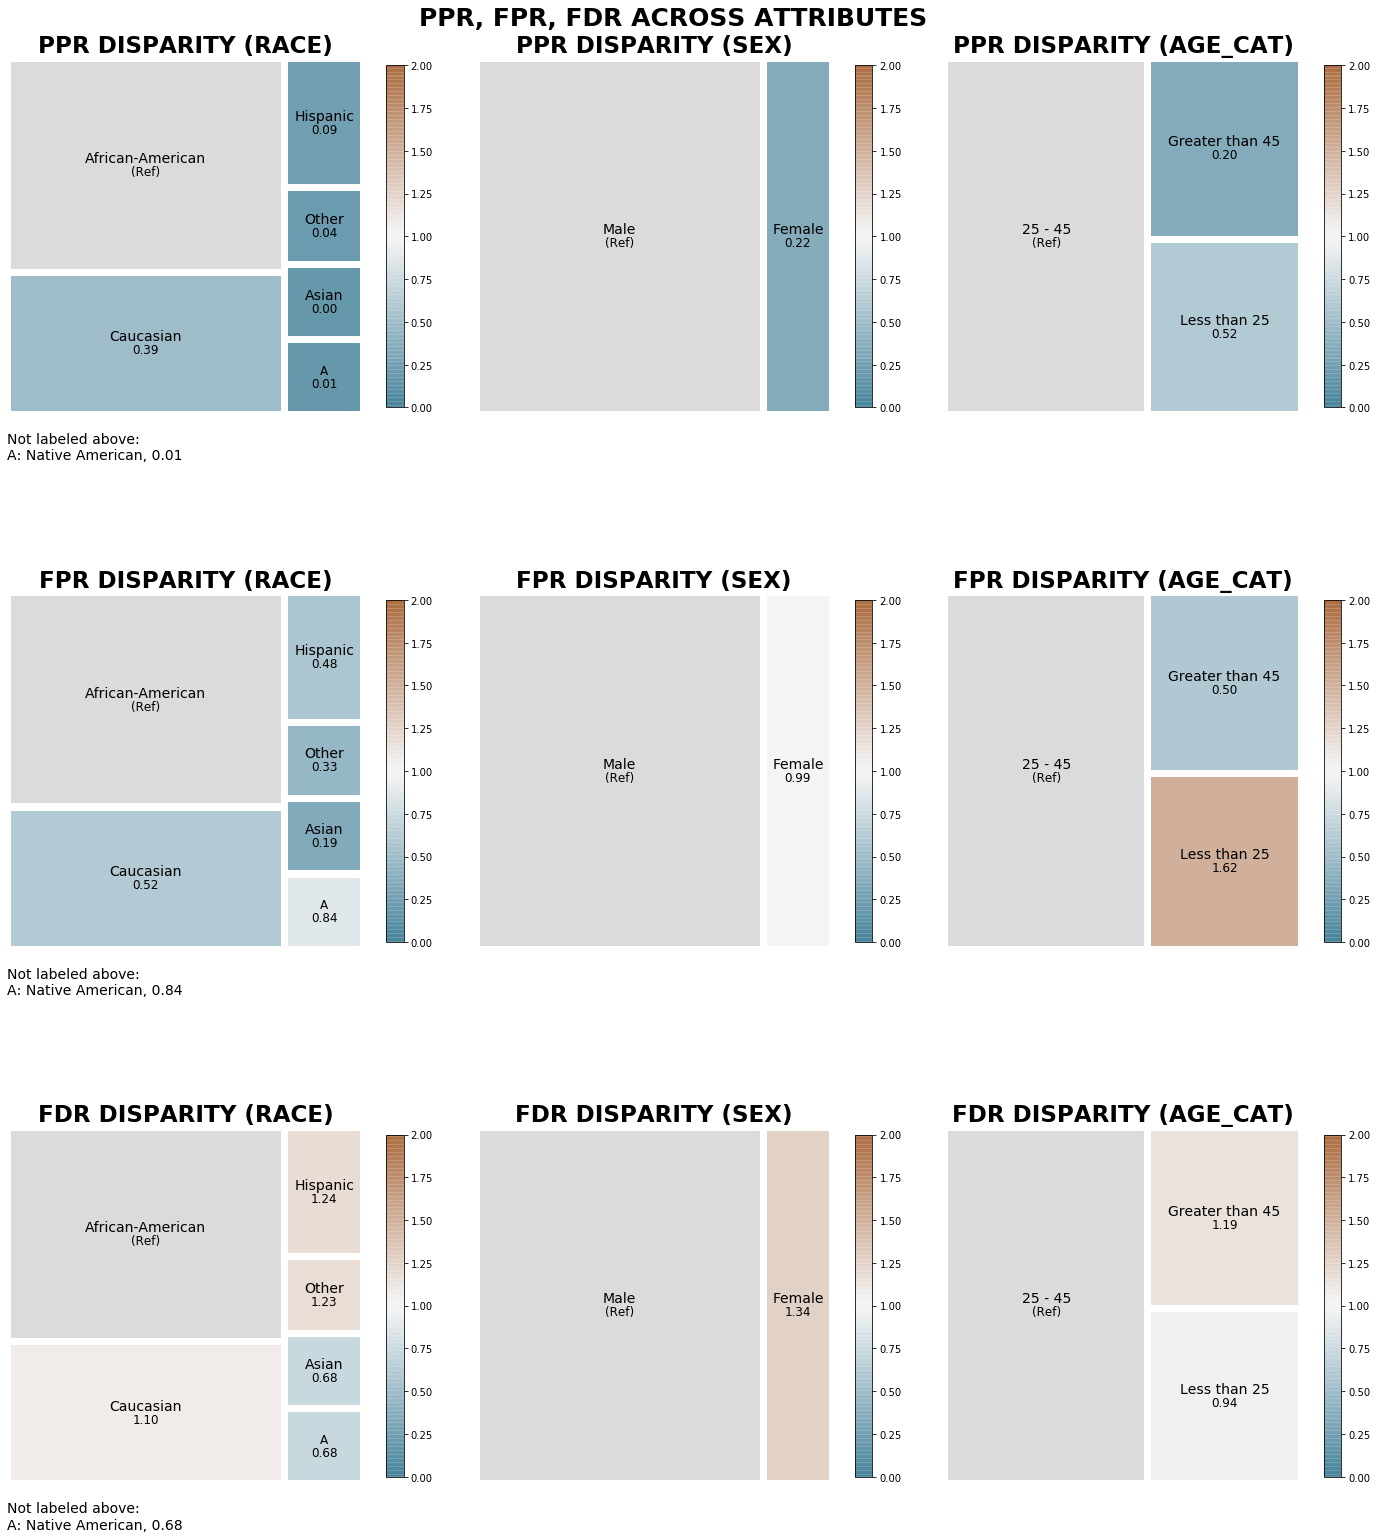

In [29]:
p = aeq.plot_disparity_all(majority_bdf,  metrics=['ppr','fpr','fdr'], significance_alpha=0.05)

### Fairness

Ahora que ya tenemos las disparidades por grupo, solo nos falta validar si la disparidad cae dentro del rango propuesto como "justo".

Recuerda que el rango de "justo" está dictado por: 

$$0.8\lt Disparity_{FNR}=\frac{FNR_{group}}{FNR_{basegroup}}\lt1.25$$

Para ello utilizamos la clase `Fairness()`.



Se puede verificar la equidad en 3 niveles: grupos, atributos, general.

1. Equidad a nivel de grupo: Ocupamos el método `get_group_value_fairness()` que recibe como entrada alguno de los data frames generados a través de la clase `Bias`.

`False` es injusto, `True` es justo.

In [30]:
fair = Fairness()

In [31]:
fdf = fair.get_group_value_fairness(bdf)

/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/home/silil/.pyenv/versions/itam/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


In [32]:
parity_determinations = fair.list_parities(fdf)

In [33]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Statistical Parity,NPV Parity,FDR Parity,Precision Parity,Impact Parity,TNR Parity,FNR Parity,Equalized Odds,FPR Parity,FOR Parity
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,...,False,True,True,True,False,False,False,False,False,True
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,...,False,True,False,False,False,True,False,False,False,False
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,...,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,...,False,True,True,True,True,True,True,True,True,True
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,...,False,True,False,False,False,True,False,False,False,False
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,...,False,True,True,True,False,True,False,False,False,True
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,...,False,True,False,True,True,True,True,True,True,False
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,...,True,True,True,True,True,True,True,True,True,True
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,...,True,True,True,True,True,True,True,True,True,True
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,...,False,True,True,True,False,True,False,False,False,False


In [34]:
fairness = fdf[['attribute_name', 'attribute_value'] + absolute_metrics + 
    bias.list_disparities(fdf) + parity_determinations].round(2)

In [35]:
fairness[['attribute_name', 'attribute_value', 'fdr', 'for','fpr','fnr']]

,attribute_name,attribute_value,fdr,for,fpr,fnr
0,race,African-American,0.37,0.35,0.45,0.28
1,race,Asian,0.25,0.12,0.09,0.33
2,race,Caucasian,0.41,0.29,0.23,0.48
3,race,Hispanic,0.46,0.29,0.21,0.56
4,race,Native American,0.25,0.17,0.38,0.10
5,race,Other,0.46,0.30,0.15,0.68
6,sex,Female,0.49,0.24,0.32,0.39
7,sex,Male,0.36,0.33,0.32,0.37
8,age_cat,25 - 45,0.39,0.32,0.33,0.37
9,age_cat,Greater than 45,0.46,0.24,0.17,0.57


2. Equidad a nivel de atributos. Ocupamos el método `get_group_attribute_fairness()`

In [98]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False
1,1,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,1,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


3. Equidad general: Ocupamos el método `get_overall_fairness()`

In [102]:
fdf

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,1,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,...,False,False,False,True,True,False,False,False,False,False
1,1,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,...,False,False,True,True,False,False,False,False,False,False
2,1,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,...,True,True,True,True,True,True,True,True,True,True
3,1,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,...,True,True,True,True,True,True,True,True,False,True
4,1,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,...,False,False,True,True,False,False,False,False,False,False
5,1,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,...,False,False,True,True,True,False,False,False,False,False
6,1,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,...,True,True,True,True,True,False,False,True,False,False
7,1,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,...,True,True,True,True,True,True,True,True,True,True
8,1,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,...,True,True,True,True,True,True,True,True,True,True
9,1,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,...,False,False,True,True,True,False,False,False,False,False


In [101]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### Visualización de equidad 

La visualización de equidad la puedes ver por grupo o por atributo, y cada uno por una métrica particular o varias al mismo tiempo. 

1. Equidad por grupo: 
* `plot_fairness_group()`
* `plot_fairness_group_all()`

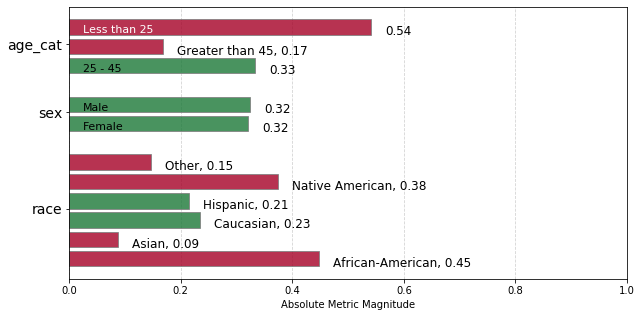

In [103]:
z = aeq.plot_fairness_group(fdf, group_metric='fpr')

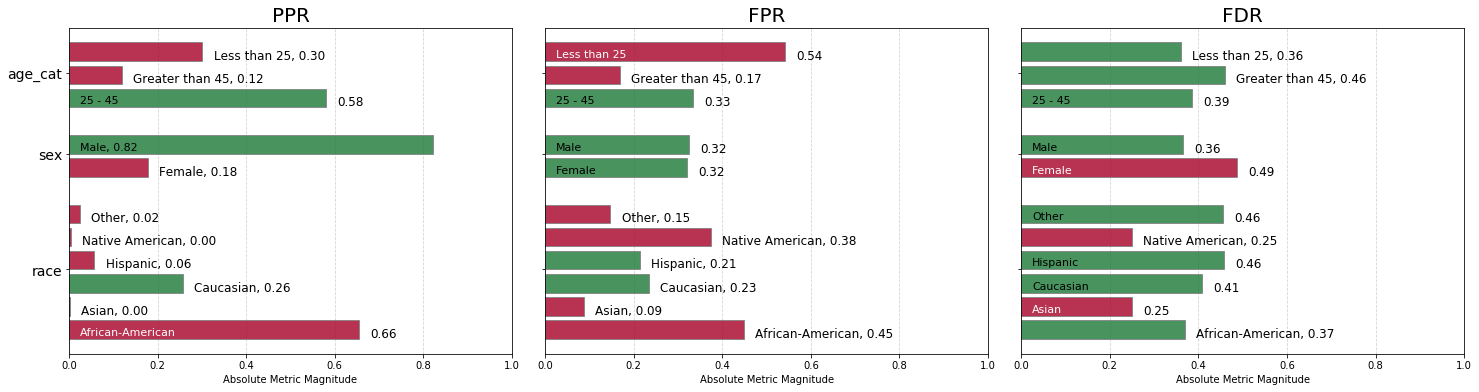

In [104]:
z = aeq.plot_fairness_group_all(fdf, metrics=['ppr','fpr','fdr'])

2. Equidad por atributo
* `plot_fairness_disparity()`
* `plot_fairness_disparity_all()`

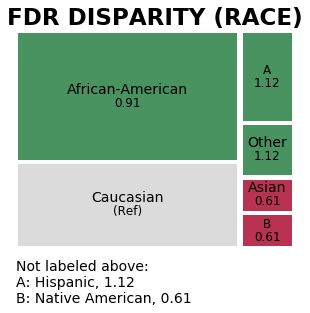

In [106]:
m = aeq.plot_fairness_disparity(fdf, group_metric='fdr', attribute_name='race')

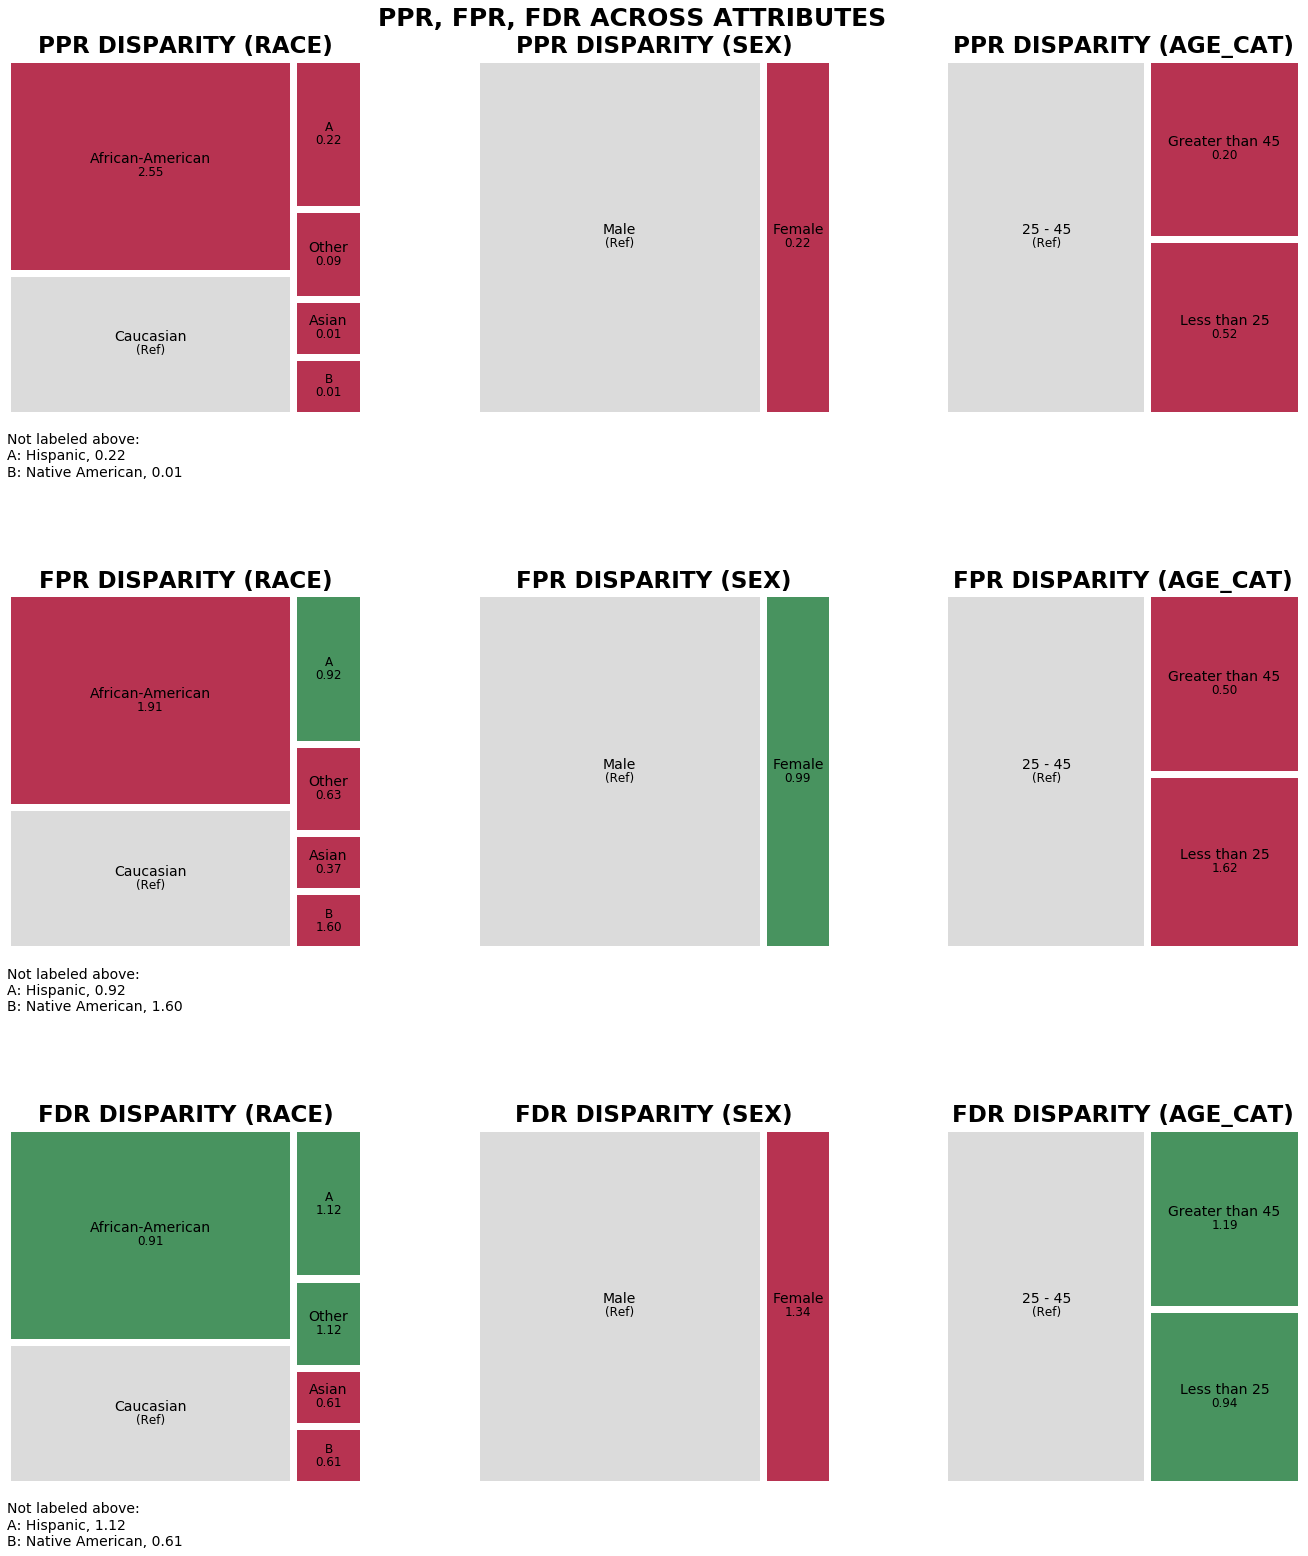

In [107]:
m = aeq.plot_fairness_disparity_all(fdf, metrics=['ppr','fpr','fdr'])

### Referencias 

+ [Aequitas with Python](https://dssg.github.io/aequitas/using_python.html)